##Midterm Project
In this project, a logistic regression algorithm is implemented and later applied on the dataset collected from UCI database. Dataset information is provided in https://archive.ics.uci.edu/ml/datasets/QSAR+oral+toxicity

First of all, Lets open the dataset and show the top 5 entries

In [93]:
import pandas as pd
import numpy as np

link = 'https://raw.githubusercontent.com/tamjidimtiaz/EEE-6002-Privacy_Preserving_Machine_Learning/main/Dataset/qsar_oral_toxicity.csv'

qsar_data = pd.read_csv(link, sep = ';', header = None)

qsar_data.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative


Let's check how many data points we have.

In [94]:
qsar_data.shape

(8992, 1025)

Let's check that if the dataset contains any null values

In [95]:
qsar_data.isnull().sum()

0       0
1       0
2       0
3       0
4       0
       ..
1020    0
1021    0
1022    0
1023    0
1024    0
Length: 1025, dtype: int64

Let's find the positive and negative class samples and handle them to make a balanced dataset

In [96]:
# find the positive and negative class samples and create a balanced dataset
positive=qsar_data[qsar_data[1024]=='positive']
negative=qsar_data[qsar_data[1024]=='negative'].sample(n=positive.shape[0])
final=pd.concat([positive,negative])

features = final.iloc[:,:-1].values 

# create the target set 
target = final.iloc[:,-1:].values
target[target=='positive'] = 1
target[target=='negative'] = 0

target = target.astype('float')

Create training, validation and testing dataset. The split is considered as 70-10-20

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) 

Check the amount of samples in each sets

In [99]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

1036
297
149


## Logistic Regression 


In [100]:
class LogisticRegression(object):
    """
    Logistic Regression Classifier
    """
    def __init__(self, max_iter=8000):
        self.max_iter       = max_iter

    def sigmoid_activation(self, result):
        result = result.astype('float')
        final_result = 1/(1+np.exp(-result))
        return final_result
    def model_optimize(self, w, b, X, Y, reg_par):
        m = X.shape[0]
        
        #Prediction
        final_result = self.sigmoid_activation(np.dot(w,X.T)+b)
        Y_T = Y.T
        cost = (-1/m)*(np.sum((Y_T*np.log(final_result)) + ((1-Y_T)*(np.log(1-final_result))))) 
        #
        
        #Gradient calculation
        dw = (1/m)*(np.dot(X.T, (final_result-Y.T).T))-((reg_par*w.T/m))
        db = (1/m)*(np.sum(final_result-Y.T))
        
        grads = {"dw": dw, "db": db}
        
        return grads, cost
    def fit(self, w, b, X, Y, X_v , Y_v, learning_rate, no_iterations, reg_par, early_stopping):
        costs = []
        costs_val = []
        cost_val_temp = 10000
        db = []
        normJ = []
        reqit = no_iterations
        for i in range(no_iterations):
            #
            grads, cost = self.model_optimize(w,b,X,Y,reg_par)
            grads_val, cost_val = self.model_optimize(w,b,X_v,Y_v,reg_par)
            #
            dw = grads["dw"]
            normJp=(np.sqrt(np.sum(np.square(dw))))
            db = grads["db"]
            #weight update
            w = w - (learning_rate * (dw.T))
            b = b - (learning_rate * db)
            #
            if (i % 10 == 0):
                normJ.append(normJp)
            if (i % 10 == 0):
                costs_val.append(cost_val)       
            if (i % 10 == 0):
                costs.append(cost)
            if (early_stopping == 1):
              if (cost_val < cost_val_temp):
                cost_val_temp = cost_val
                reqit = i
                continue
              else:
                break
            else:
              continue

        #final parameters
        coeff = {"w": w, "b": b}
        gradient = {"dw": dw, "db": db}
        
        return reqit,coeff, normJ, costs, costs_val
    def predict(self, final_pred, m, threshold):
        y_pred = np.zeros((1,m))
        y_pred[final_pred>threshold] = 1

        return y_pred

##Training and Validation Accuracy

In [101]:

from sklearn.metrics import accuracy_score

def weightInitialization(n_features):
        w = np.zeros((1,n_features))
        b = 0
        return w,b

n_features = X_train.shape[1]
print('Number of Features', n_features)
w, b = weightInitialization(n_features)

iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train, y_train, X_val, y_val, learning_rate=0.01,no_iterations=16000, reg_par = 0.04, early_stopping = 1)
  
#Final prediction
w = coeff["w"]
b = coeff["b"]

print('Optimized weights', w)
print('Optimized intercept',b)


#
final_train_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_train.T)+b)
final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_val.T)+b)
#
m_tr =  X_train.shape[0]
m_ts =  X_val.shape[0]
#
y_tr_pred = LogisticRegression().predict(final_train_pred, m_tr, 0.5)
y_tr_pred = y_tr_pred.T 
print('Training Accuracy',accuracy_score(y_tr_pred, y_train))
#
y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, 0.5)
y_ts_pred = y_ts_pred.T 
print('Validation Accuracy',accuracy_score(y_ts_pred, y_val))

Number of Features 1024
Optimized weights [[ 0.05595286  0.10572245  0.19802415 ... -0.07992155 -0.02817128
  -0.12615165]]
Optimized intercept -0.1446027210844077
Training Accuracy 0.9073359073359073
Validation Accuracy 0.8322147651006712


##Precision & Recall Vs threshold

Test Accuracy 0.5824915824915825
Test Accuracy 0.6161616161616161
Test Accuracy 0.6734006734006734
Test Accuracy 0.7003367003367004
Test Accuracy 0.7239057239057239
Test Accuracy 0.7239057239057239
Test Accuracy 0.734006734006734
Test Accuracy 0.7205387205387206
Test Accuracy 0.6363636363636364


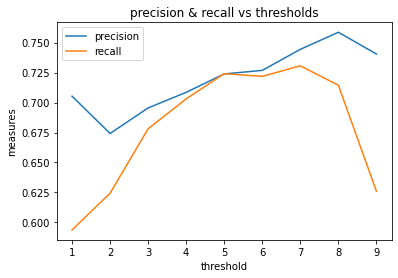

In [102]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
%matplotlib inline


thresholds = range(1,10,1)
precisions = []
recalls = []
for i in thresholds:
  final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T)+b)
  m_ts =  X_test.shape[0]
  y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, i*0.1)
  y_ts_pred = y_ts_pred.T 
  print('Test Accuracy',accuracy_score(y_ts_pred, y_test))
  precisions.append(precision_score(y_test, y_ts_pred, average='macro'))
  recalls.append(recall_score(y_test, y_ts_pred, average='macro'))

plt.plot(thresholds,precisions)
plt.plot(thresholds,recalls)
plt.ylabel('measures')
plt.xlabel('threshold')
plt.title('precision & recall vs thresholds')
plt.legend(["precision", "recall"])

##ROC Curve

Text(0.5, 1.0, 'ROC CURVE')

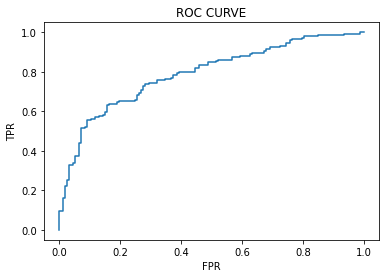

In [103]:
scores = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T)+b)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores.T, pos_label=1)
plt.plot(fpr,tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC CURVE')

## Cost Vs Iteration

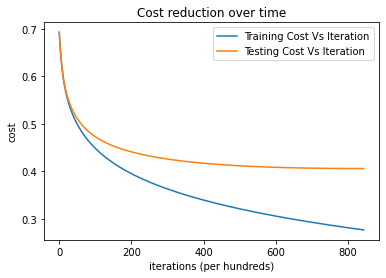

In [104]:

plt.plot(costs)
plt.plot(costs_val)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Cost reduction over time')
plt.legend(["Training Cost Vs Iteration", "Testing Cost Vs Iteration"])

## Norm of the gradients vs Iterations

Text(0.5, 1.0, 'Norm of the gradient vs iterations')

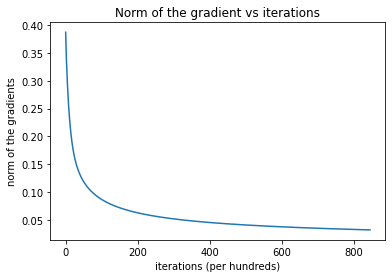

In [105]:

plt.plot(gradient)
plt.ylabel('norm of the gradients')
plt.xlabel('iterations (per hundreds)')
plt.title('Norm of the gradient vs iterations')
# plt.legend(["Training Cost Vs Iteration", "Testing Cost Vs Iteration"])

## Cost Vs Regularization Parameter

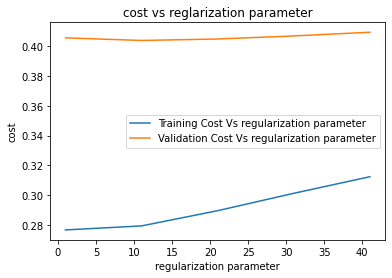

In [110]:


costslam = []
valcostslam = []
j =  [x for x in range(1,50,10)]
for i in j:
  w, b = weightInitialization(n_features)
  iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train, y_train, X_val, y_val, learning_rate=0.01, no_iterations=8000, reg_par = i, early_stopping = 1)
  costslam.append(costs[-1])
  valcostslam.append(costs_val[-1])
  

plt.plot(j,costslam)
plt.plot(j,valcostslam)
plt.ylabel('cost')
plt.xlabel('regularization parameter')
plt.title('cost vs reglarization parameter')
plt.legend(["Training Cost Vs regularization parameter", "Validation Cost Vs regularization parameter"])


##Required Iterations vs step size

Text(0.5, 1.0, 'Reqired Iterations vs step size')

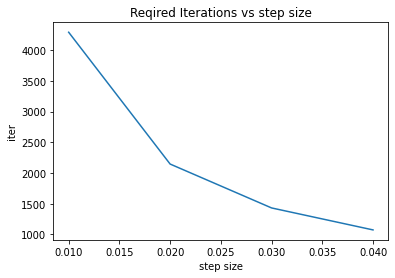

In [108]:

j =  [x*0.01 for x in range(1,5)]
iters = []
for i in j:
  w, b = weightInitialization(n_features)
  iter, coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train, y_train, X_val, y_val, learning_rate=i, no_iterations=8000, reg_par = 20, early_stopping = 1)  
  iters.append(iter)

plt.plot(j,iters)

plt.ylabel('iter')
plt.xlabel('step size')
plt.title('Reqired Iterations vs step size')
# plt.legend(["Training Cost Vs sample size", "Testing Cost Vs sample size"])


## Cost Vs Sample Size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


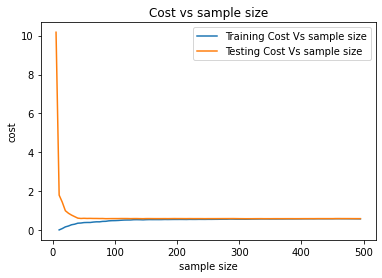

In [109]:
costsam = []
valcostsam = []

j = range(5,500,5)

for i in range(5, 500, 5):
  w, b = weightInitialization(n_features)
  iter, coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train[1:i,:], y_train[1:i], X_val, y_val, learning_rate=0.01, no_iterations=100, reg_par = 20, early_stopping = 0)  
  costsam.append(costs[-1])
  valcostsam.append(costs_val[-1])

plt.plot(j,costsam)
plt.plot(j,valcostsam)
plt.ylabel('cost')
plt.xlabel('sample size')
plt.title('Cost vs sample size')
plt.legend(["Training Cost Vs sample size", "Testing Cost Vs sample size"])
